#Predicting Remaining Useful Life (RUL) of Jet Engines Using LSTM Regression on NASA Turbofan Dataset
This project focuses on predicting the Remaining Useful Life (RUL) of jet engines using the NASA Turbofan Jet Engine Data Set. RUL is a critical metric that represents the time or cycles remaining before an engine fails or requires maintenance. Accurate RUL prediction is essential for effective predictive maintenance, reducing downtime, improving safety, and optimizing operational costs in aerospace and other industries.

The dataset contains sensor readings and operational settings collected from simulated engines operating under varying conditions. Each engine runs until failure, providing rich temporal data for modeling.

To predict RUL, I use a Long Short-Term Memory (LSTM) regressor, a type of recurrent neural network (RNN) well-suited for sequential data. LSTMs are designed to capture long-term dependencies and patterns in time-series data, making them ideal for analyzing the temporal relationships in the engine sensor readings. The model is trained to map sequences of sensor data to the corresponding RUL, enabling it to generalize and predict the RUL of unseen engines.

By combining advanced machine learning techniques and real-world engine data, this project aims to provide an accurate and reliable approach to estimating RUL for predictive maintenance applications.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Load data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('bmh')

In [3]:
column_names = ['engine', 'time', 'op_setting_1', 'op_setting_2',
                'op_setting_3'] + [f'sm_{i}' for i in range(1, 22)]

# assign names to columns , save in dict_list
Sensor_dictionary={}
dict_list=[ "(Fan inlet temperature) (◦R)",
"(LPC outlet temperature) (◦R)",
"(HPC outlet temperature) (◦R)",
"(LPT outlet temperature) (◦R)",
"(Fan inlet Pressure) (psia)",
"(bypass-duct pressure) (psia)",
"(HPC outlet pressure) (psia)",
"(Physical fan speed) (rpm)",
"(Physical core speed) (rpm)",
"(Engine pressure ratio(P50/P2)",
"(HPC outlet Static pressure) (psia)",
"(Ratio of fuel flow to Ps30) (pps/psia)",
"(Corrected fan speed) (rpm)",
"(Corrected core speed) (rpm)",
"(Bypass Ratio) ",
"(Burner fuel-air ratio)",
"(Bleed Enthalpy)",
"(Required fan speed)",
"(Required fan conversion speed)",
"(High-pressure turbines Cool air flow)",
"(Low-pressure turbines Cool air flow)" ]

i=1
for x in dict_list :
    Sensor_dictionary[f'sm_{i}']=x
    i+=1
Sensor_dictionary

{'sm_1': '(Fan inlet temperature) (◦R)',
 'sm_2': '(LPC outlet temperature) (◦R)',
 'sm_3': '(HPC outlet temperature) (◦R)',
 'sm_4': '(LPT outlet temperature) (◦R)',
 'sm_5': '(Fan inlet Pressure) (psia)',
 'sm_6': '(bypass-duct pressure) (psia)',
 'sm_7': '(HPC outlet pressure) (psia)',
 'sm_8': '(Physical fan speed) (rpm)',
 'sm_9': '(Physical core speed) (rpm)',
 'sm_10': '(Engine pressure ratio(P50/P2)',
 'sm_11': '(HPC outlet Static pressure) (psia)',
 'sm_12': '(Ratio of fuel flow to Ps30) (pps/psia)',
 'sm_13': '(Corrected fan speed) (rpm)',
 'sm_14': '(Corrected core speed) (rpm)',
 'sm_15': '(Bypass Ratio) ',
 'sm_16': '(Burner fuel-air ratio)',
 'sm_17': '(Bleed Enthalpy)',
 'sm_18': '(Required fan speed)',
 'sm_19': '(Required fan conversion speed)',
 'sm_20': '(High-pressure turbines Cool air flow)',
 'sm_21': '(Low-pressure turbines Cool air flow)'}

In [4]:
# this is RUL of each engine on test set. 100 row
data_val = pd.read_csv('/content/drive/MyDrive/proyects_indep/proyect_NASA/CMaps/test_FD001.txt' , sep = ' ' , header=None ,
                      names=column_names ,index_col=False )
y_val = pd.read_csv('/content/drive/MyDrive/proyects_indep/proyect_NASA/CMaps/RUL_FD001.txt' , header=None , names=['RUL'] )

data_val.shape , y_val.shape

data_train = pd.read_csv('/content/drive/MyDrive/proyects_indep/proyect_NASA/CMaps/train_FD001.txt' , sep = ' ' , header=None,
                           names=column_names , index_col=False )
data_train.shape

<ipython-input-4-c40f4117eb5a>:2: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  data_val = pd.read_csv('/content/drive/MyDrive/proyects_indep/proyect_NASA/CMaps/test_FD001.txt' , sep = ' ' , header=None ,
<ipython-input-4-c40f4117eb5a>:8: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  data_train = pd.read_csv('/content/drive/MyDrive/proyects_indep/proyect_NASA/CMaps/train_FD001.txt' , sep = ' ' , header=None,


(20631, 26)

In [5]:
data_val.head()

,engine,time,op_setting_1,op_setting_2,op_setting_3,sm_1,sm_2,sm_3,sm_4,sm_5,...,sm_12,sm_13,sm_14,sm_15,sm_16,sm_17,sm_18,sm_19,sm_20,sm_21
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130


In [6]:
y_val.head()

,RUL
0,112
1,98
2,69
3,82
4,91


In [7]:
data_train.head()

,engine,time,op_setting_1,op_setting_2,op_setting_3,sm_1,sm_2,sm_3,sm_4,sm_5,...,sm_12,sm_13,sm_14,sm_15,sm_16,sm_17,sm_18,sm_19,sm_20,sm_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


## data cleaning

In [8]:
# usefull info of dataset
df_info = pd.concat ( [data_train.isna().sum() , data_train.nunique() , data_train.dtypes] , axis = 1  )
df_info.columns = ['missing value' , 'number unique value' , 'dtype']
df_info
# no missing value , no categorical value

,missing value,number unique value,dtype
engine,0,100,int64
time,0,362,int64
op_setting_1,0,158,float64
op_setting_2,0,13,float64
op_setting_3,0,1,float64
sm_1,0,1,float64
sm_2,0,310,float64
sm_3,0,3012,float64
sm_4,0,4051,float64
sm_5,0,1,float64


#Data preprocessing

In [9]:
# make copy of original dataset , assing new name for dataframes
df = data_train.copy()
df_val = data_val.copy()
print(df.shape , df_val.shape)

(20631, 26) (13096, 26)


### detect and drop constant features

In [10]:
def constant_feature(df):
  constant_feature = []
  for col in df.columns:
          if abs(df[col].std() < 0.02):      # hint
              constant_feature.append(col)

  return constant_feature

#### hint

*   Elemento de lista
*   Elemento de lista


we can use
    
    df[col].min() == df[col].max()

Drop features with a standard deviation less than 0.02. This identifies features with minimal variation, indicating they are likely constant or nearly constant. While using `df[col].min() == df[col].max()` can also detect constant features, it might miss features with a few slightly different values. The standard deviation provides a more robust measure of variability.
for example , sm_6 has 21.6 for 400 sample , and for rest sample(26000-400) is 21.61.
so min = max , will not consider constant , but it can consider constant,variation is veryyy small

In [11]:
df = data_train.copy()
df_val = data_val.copy()

print( constant_feature(df) )
constant_feature = constant_feature(df)

df.drop(columns=constant_feature , inplace = True)
df_val.drop(columns=constant_feature, inplace = True)

print(df.shape, df_val.shape)
df.columns

['op_setting_1', 'op_setting_2', 'op_setting_3', 'sm_1', 'sm_5', 'sm_6', 'sm_10', 'sm_16', 'sm_18', 'sm_19']
(20631, 16) (13096, 16)


Index(['engine', 'time', 'sm_2', 'sm_3', 'sm_4', 'sm_7', 'sm_8', 'sm_9',
       'sm_11', 'sm_12', 'sm_13', 'sm_14', 'sm_15', 'sm_17', 'sm_20', 'sm_21'],
      dtype='object')

### create rul feature

In [12]:
# defining RUL for training dataset
# RUL is rest useful life for each engines instant
# for engine 1 , max time will be true RUL , we can subtract every time from max time
# it gives us rul for each engins' states
# it is grouped data by engine , and for every engine , take time's columns , and take max value of time
# assign max times of each engine for all of engine's , then subtract it by its time , result is rul
def create_rul(df):
    df['rul'] = df.groupby('engine')['time'].transform('max') - df['time']
    return df
df = create_rul(df)
#df_val = create_rul(df_val)

### detect high corrolated features

In [13]:
mask = np.triu(np.ones(df.shape).astype(bool))
# np.ones( shape of matrix)    return matrix with 1 , shape is specified
# np.triu( matrix , k = 1 )    return upper triangle of matrix , k = 1 exclude diagnoal , k = 0 diagnoal included
# mask is a matrix with 0 value for all shape expect upper triangle

In [14]:
df_corr = df.corr()
mask = np.tril(np.ones(df_corr.shape),k = -1).astype(bool)
df_corr = df_corr.where(mask)
df_corr

,engine,time,sm_2,sm_3,sm_4,sm_7,sm_8,sm_9,sm_11,sm_12,sm_13,sm_14,sm_15,sm_17,sm_20,sm_21,rul
engine,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
time,0.078753,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sm_2,0.014133,0.549898,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sm_3,0.012621,0.543947,0.602610,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sm_4,0.026116,0.624577,0.714949,0.678413,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sm_7,-0.032073,-0.595914,-0.702136,-0.664595,-0.793130,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sm_8,0.039929,0.475977,0.662325,0.602481,0.746852,-0.767132,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sm_9,-0.052053,0.443999,0.273764,0.322964,0.297429,-0.217835,-0.032091,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sm_11,0.024707,0.634385,0.740020,0.695900,0.830136,-0.822805,0.782213,0.274591,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sm_12,-0.031882,-0.611354,-0.724578,-0.680307,-0.815591,0.812713,-0.786540,-0.210238,-0.846884,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<Axes: title={'center': 'correlation'}>

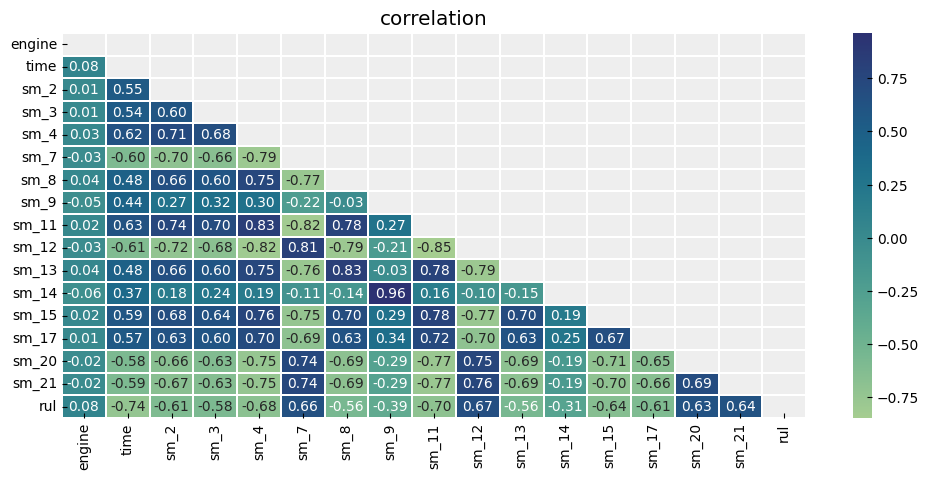

In [15]:
plt.figure(figsize = (12,5))
plt.grid() , plt.title('correlation')
sns.heatmap(df_corr , annot=True , fmt = '0.2f' , cmap='crest' , linewidths=0.01)

rul has good correlation with sensor measurements.
engine is ID , so it is irrelevant

<Axes: >

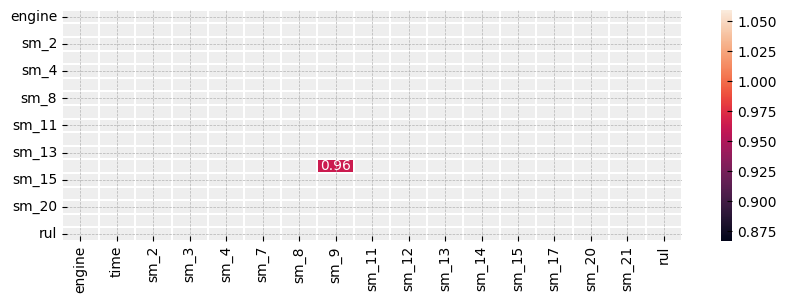

In [16]:
# visualization high corrolated features
plt.figure(figsize = (10,3))
mask = df_corr.where( abs(df_corr) > 0.95 ).isna()
sns.heatmap(df_corr , annot=True , fmt = '0.2f' , linewidths=0.1 , mask = mask )

In [17]:
# detect more than 95% correlation
high_corr = []
for col in df_corr.columns:
    for row in df_corr.index:
        if abs(df_corr.loc[col , row]) > 0.95 :
            high_corr.append((col , row))
high_corr

[('sm_14', 'sm_9')]

In [18]:
# these 2 feature has very high correlation , no need for both of them , we can drop one of them
df.drop(columns = ['sm_9'] , inplace = True)
#Drop the same column on val_dataset
df_val.drop(columns = ['sm_9'] , inplace = True)

In [19]:
print(df.shape)
print(df.columns)

print(df_val.shape)
print(df_val.columns)

(20631, 16)
Index(['engine', 'time', 'sm_2', 'sm_3', 'sm_4', 'sm_7', 'sm_8', 'sm_11',
       'sm_12', 'sm_13', 'sm_14', 'sm_15', 'sm_17', 'sm_20', 'sm_21', 'rul'],
      dtype='object')
(13096, 15)
Index(['engine', 'time', 'sm_2', 'sm_3', 'sm_4', 'sm_7', 'sm_8', 'sm_11',
       'sm_12', 'sm_13', 'sm_14', 'sm_15', 'sm_17', 'sm_20', 'sm_21'],
      dtype='object')


#LSTM regressor

##Separate data by engine, split data an reorder it for the LSTM.

In [32]:
import numpy as np

def create_sequences(features, labels, sequence_length):
    """
    Creates sequences of features and their corresponding labels for a given sequence length.

    Args:
        features (array-like): Input feature data.
        labels (array-like): Target labels corresponding to the features.
        sequence_length (int): Length of the sequences to be generated.

    Returns:
        tuple: A tuple containing:
            - X (np.array): 3D array of shape (num_sequences, sequence_length, num_features).
            - y (np.array): 1D array of shape (num_sequences,), containing the corresponding labels.
    """
    X, y = [], []
    for i in range(sequence_length, len(features)):
        X.append(features[i-sequence_length:i])  # Extract a sequence of features
        y.append(labels[i])  # Add the corresponding label
    return np.array(X), np.array(y)


def ordering_dataset(df, sequence_length):
    """
    Prepares the dataset by generating sequences for each unique engine in the dataset.

    Args:
        df (DataFrame): Input dataset with features, labels, and engine identifiers.
        sequence_length (int): Length of the sequences to be generated.

    Returns:
        tuple: A tuple containing:
            - X (np.array): 3D array of shape (total_sequences, sequence_length, num_features).
            - Y (np.array): 1D array of shape (total_sequences,), containing the corresponding labels.
    """
    max_engine = df['engine'].max() + 1  # Determine the number of unique engines
    features = []
    labels = []

    for i in range(1, max_engine):
        # Filter data for a specific engine
        filtered = df[df['engine'] == i]
        filtered = filtered.to_numpy()
        features.append(filtered[:, 2:-1])  # Extract feature columns
        labels.append(filtered[:, -1])  # Extract label column

    print(features[0].shape, labels[0].shape)

    # Initialize storage for sequences
    X, Y = [], []

    len_data = len(features)
    for i in range(len_data):
        # Generate sequences for each engine
        x, y = create_sequences(features[i], labels[i], sequence_length)
        # Append sequences for each engine
        X.append(x)
        Y.append(y)

    print('Shape engine 0:', X[0].shape, Y[0].shape)
    print('Number of engines:', len(X), len(Y))

    # Flatten the data across all engines
    X = np.array([element for sublist in X for element in sublist])
    print('X :', X.shape)
    Y = np.array([element for sublist in Y for element in sublist])
    print('y :', Y.shape)

    return X, Y


def ordering_dataset_val(df_val, sequence_length, y_val):
    """
    Prepares validation data by taking the last rows for each engine
    to form sequences and corresponding validation labels.

    Args:
        df_val (DataFrame): Validation dataset containing features and engine identifiers.
        sequence_length (int): Length of the sequences to be generated.
        y_val (Series or array-like): Validation labels.

    Returns:
        tuple: A tuple containing:
            - X_val (np.array): 3D array of shape (num_engines, sequence_length, num_features).
            - y_val (np.array): 1D array of validation labels.
    """
    # Select the last 'sequence_length' rows per engine
    df_val_x = df_val.groupby('engine').apply(lambda x: x.tail(sequence_length)).reset_index(drop=True)

    max_engine = df_val['engine'].max() + 1  # Determine the number of unique engines
    features = []

    for i in range(1, max_engine):
        # Filter data for a specific engine
        filtered = df_val_x[df_val_x['engine'] == i]
        features.append(filtered.iloc[:, 2:df_val_x.shape[1]].to_numpy())  # Drop 'engine' and 'time' columns

    X_val = np.array(features)
    y_val = y_val.to_numpy().ravel()  # Flatten validation labels
    return X_val, y_val


This cell prepares the datasets for training, testing, and validation for an LSTM model. It begins by defining the sequence length that the LSTM will process and organizes the input data (X) and labels (Y) using the ordering_dataset function. The validation set (X_val and y_val) is prepared by loading and processing the Remaining Useful Life (RUL) values from a file and applying the ordering_dataset_val function.

The data is then split into training and testing subsets using train_test_split, with 80% allocated to training and 20% to testing. Finally, the shapes of the training, testing, and validation datasets are printed to confirm proper preparation of the data for the LSTM model.

In [33]:
# train set
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
#Lenght of the sequence that LSTM will receive
sequence_length = 20
#Ordering datasets
X, Y = ordering_dataset(df, sequence_length)
y_val = pd.read_csv('/content/drive/MyDrive/proyects_indep/proyect_NASA/CMaps/RUL_FD001.txt'
                    , header=None , names=['RUL'] )
X_val, y_val = ordering_dataset_val(df_val, sequence_length, y_val)

#Split data per engine
X_train , X_test , y_train , y_test  = train_test_split(X, Y, test_size=0.2 , random_state=42)

print('X train:', X_train.shape)
print('X test:', X_test.shape)
print('X val:', X_val.shape)
print('y train:', y_train.shape)
print('y test:', y_test.shape)
print('y val:', y_val.shape)

(192, 13) (192,)
Shape engine 0: (172, 20, 13) (172,)
Number of engines: 100 100
X : (18631, 20, 13)
y : (18631,)
X train: (14904, 20, 13)
X test: (3727, 20, 13)
X val: (100, 20, 13)
y train: (14904,)
y test: (3727,)
y val: (100,)


<ipython-input-32-fd7bd8a0b380>:89: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_val_x = df_val.groupby('engine').apply(lambda x: x.tail(sequence_length)).reset_index(drop=True)


##Normalization

In [34]:
from sklearn.preprocessing import StandardScaler

def normalize_data(X, scaler):
    """
    Normalizes the input data using a standard scaler. If no scaler is provided,
    it creates and fits a new StandardScaler. Otherwise, it applies the provided scaler.

    Args:
        X (np.array): Input data, typically a 3D array of shape (batch_size, sequence_length, num_features).
        scaler (StandardScaler or bool): If False, a new scaler will be created and fitted.
                                         If a StandardScaler object is provided, it will be used to normalize the data.

    Returns:
        tuple or np.array:
            - If a new scaler is created, returns a tuple (X_normalized, scaler), where:
                - X_normalized (np.array): The normalized data with the same shape as the input.
                - scaler (StandardScaler): The fitted scaler.
            - If an existing scaler is used, returns X_normalized (np.array) directly.
    """
    if scaler == False:
        # Flatten the data to shape (n_samples, n_features)
        X_flat = X.reshape(-1, X.shape[-1])  # Shape: (batch_size * sequence_length, num_features)
        print(X_flat.shape)

        # Create and fit the scaler
        scaler = StandardScaler()
        X_flat_normalized = scaler.fit_transform(X_flat)

        # Restore the original shape of the data
        X_normalized = X_flat_normalized.reshape(X.shape)
        return X_normalized, scaler
    else:
        # Flatten the data to shape (n_samples, n_features)
        X_flat = X.reshape(-1, X.shape[-1])
        print(X_flat.shape)

        # Use the provided scaler to transform the data
        X_flat_normalized = scaler.transform(X_flat)

        # Restore the original shape of the data
        X_normalized = X_flat_normalized.reshape(X.shape)
        return X_normalized


X_train, scaler_X = normalize_data(X_train, scaler = False)
X_test = normalize_data(X_test, scaler_X)
X_val = normalize_data(X_val, scaler_X)
print(X_train.shape, X_test.shape, X_val.shape)

scaler_y = StandardScaler()
y_train = scaler_y.fit_transform(y_train.reshape(-1, 1)).ravel()
y_test = scaler_y.transform(y_test.reshape(-1, 1)).ravel()
y_val = scaler_y.transform(y_val.reshape(-1, 1)).ravel()
print(y_train.shape, y_test.shape, y_val.shape)

(298080, 13)
(74540, 13)
(2000, 13)
(14904, 20, 13) (3727, 20, 13) (100, 20, 13)
(14904,) (3727,) (100,)


Prepare data loaders

In [24]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 21.1 MB/s eta 0:00:00


In [36]:
# Dataset y DataLoader
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchmetrics.functional import r2_score

#Convert to tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)
#Train loader
train_dataset = TensorDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
#Test loader
test_dataset = TensorDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)
#Validation loader
val_dataset = TensorDataset(X_val, y_val)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

##Functions

In [37]:
import torch
import matplotlib.pyplot as plt

# Model definition
class LSTMModel(nn.Module):
    """
    LSTM model for sequence processing with optional bidirectionality.

    Args:
        input_size (int): Number of input features.
        hidden_size (int): Number of units in the hidden layer.
        output_size (int): Number of output features.
        bidirectional (bool): Whether to use bidirectional LSTM.

    Forward pass:
        Args:
            x (tensor): Input tensor of shape (batch_size, sequence_length, input_size).
        Returns:
            output (tensor): Output tensor of shape (batch_size, output_size).
    """
    def __init__(self, input_size, hidden_size, output_size, bidirectional=True):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True,
                            dropout=0.3, bidirectional=bidirectional)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(hidden_size * (2 if bidirectional else 1), output_size)

    def forward(self, x):
        lstm_out, (hn, cn) = self.lstm(x)
        lstm_out = lstm_out[:, -1, :]  # Take the last hidden state
        lstm_out = self.dropout(lstm_out)
        output = self.fc(lstm_out)
        return output


def compute_r2(all_predictions, all_targets):
    """
    Computes the R-squared metric for predictions.

    Args:
        all_predictions (list or tensor): Model predictions.
        all_targets (list or tensor): True target values.

    Returns:
        float: R-squared score.
    """
    # Concatenate if lists of tensors
    if isinstance(all_predictions, list):
        all_predictions = torch.cat(all_predictions, dim=0)
    if isinstance(all_targets, list):
        all_targets = torch.cat(all_targets, dim=0)

    all_predictions = all_predictions.to("cuda")
    all_targets = all_targets.to("cuda")

    # Calculate R2
    mean_target = torch.mean(all_targets)
    ss_total = torch.sum((all_targets - mean_target) ** 2)
    ss_residual = torch.sum((all_targets - all_predictions) ** 2)
    r2 = 1 - (ss_residual / ss_total)
    return r2.item()


def model_evaluation(model, test_dataloader, device):
    """
    Evaluates the model on a test dataset.

    Args:
        model (nn.Module): Trained model.
        test_dataloader (DataLoader): DataLoader for the test dataset.
        device (torch.device): Device (CPU/GPU).

    Returns:
        tuple: Validation loss, R2 score, predictions, and targets.
    """
    model.eval()
    val_loss = 0.0
    all_predictions, all_targets = [], []

    with torch.no_grad():
        for inputs, targets in test_dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            val_loss += loss.item() * inputs.size(0)
            all_predictions.append(outputs.squeeze().detach().cpu())
            all_targets.append(targets.detach().cpu())

    val_loss /= len(test_dataloader.dataset)
    all_predictions = torch.cat(all_predictions, dim=0)
    all_targets = torch.cat(all_targets, dim=0)
    val_r2 = compute_r2(all_predictions, all_targets)

    return val_loss, val_r2, all_predictions, all_targets


def graph_values(func1, func2, name1, name2, axis_x, axis_y, title):
    """
    Plots two sets of values over epochs.

    Args:
        func1, func2 (list): Values to plot.
        name1, name2 (str): Labels for the curves.
        axis_x, axis_y (str): Labels for the axes.
        title (str): Plot title.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, num_epochs + 1), func1, label=name1, color='blue')
    plt.plot(range(1, num_epochs + 1), func2, label=name2, color='red')
    plt.xlabel(axis_x)
    plt.ylabel(axis_y)
    plt.title(title)
    plt.legend()
    plt.show()


def graph_3values(func1, func2, func3, name1, name2, name3, axis_x, axis_y, title):
    """
    Plots three sets of values over epochs.

    Args:
        func1, func2, func3 (list): Values to plot.
        name1, name2, name3 (str): Labels for the curves.
        axis_x, axis_y (str): Labels for the axes.
        title (str): Plot title.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, num_epochs + 1), func1, label=name1, color='blue')
    plt.plot(range(1, num_epochs + 1), func2, label=name2, color='red')
    plt.plot(range(1, num_epochs + 1), func3, label=name3, color='green')
    plt.xlabel(axis_x)
    plt.ylabel(axis_y)
    plt.title(title)
    plt.legend()
    plt.show()


def save_best_model(model, optimizer, epoch, val_loss, best_val_loss, file_path="best_model_val.pth"):
    """
    Saves the model if the current validation loss is lower than the best recorded loss.

    Args:
        model (nn.Module): Model to save.
        optimizer (torch.optim.Optimizer): Optimizer associated with the model.
        epoch (int): Current epoch.
        val_loss (float): Validation loss of the current epoch.
        best_val_loss (float): Best validation loss so far.
        file_path (str): File path to save the model.

    Returns:
        float: Updated best validation loss.
    """
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss
        }, file_path)
        print(f"New best model saved at epoch {epoch} with Validation Loss: {val_loss:.4f}")
    return best_val_loss


##Train

This cell sets up and trains an LSTM model for Remaining Useful Life (RUL) prediction. It defines hyperparameters, initializes the model, loss function, and optimizer, and trains the model over several epochs. Training, testing, and validation losses and R² metrics are tracked, with the best validation model saved during training. Finally, results are visualized with loss and R² metrics plotted over the epochs.

Using device: cuda


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Epoch [1/10], Train Loss: 0.4361, Train R2: 0.5639
Test Loss: 0.3424, Test R2: 0.6466
Val Loss: 0.2067, Val R2: 0.5061
New best model saved at epoch 0 with Validation Loss: 0.2067
Epoch [2/10], Train Loss: 0.3579, Train R2: 0.6421
Test Loss: 0.3293, Test R2: 0.6601
Val Loss: 0.2050, Val R2: 0.5100
New best model saved at epoch 1 with Validation Loss: 0.2050
Epoch [3/10], Train Loss: 0.3430, Train R2: 0.6570
Test Loss: 0.3161, Test R2: 0.6737
Val Loss: 0.1756, Val R2: 0.5803
New best model saved at epoch 2 with Validation Loss: 0.1756
Epoch [4/10], Train Loss: 0.3280, Train R2: 0.6720
Test Loss: 0.3018, Test R2: 0.6885
Val Loss: 0.1837, Val R2: 0.5609
Epoch [5/10], Train Loss: 0.3163, Train R2: 0.6837
Test Loss: 0.2836, Test R2: 0.7073
Val Loss: 0.1682, Val R2: 0.5980
New best model saved at epoch 4 with Validation Loss: 0.1682
Epoch [6/10], Train Loss: 0.3008, Train R2: 0.6992
Test Loss: 0.2980, Test R2: 0.6924
Val Loss: 0.1327, Val R2: 0.6830
New best model saved at epoch 5 with Valid

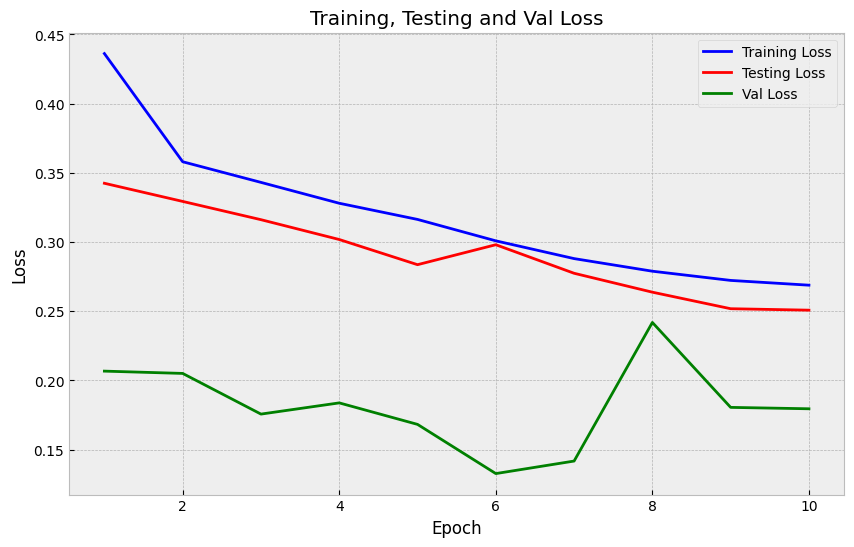

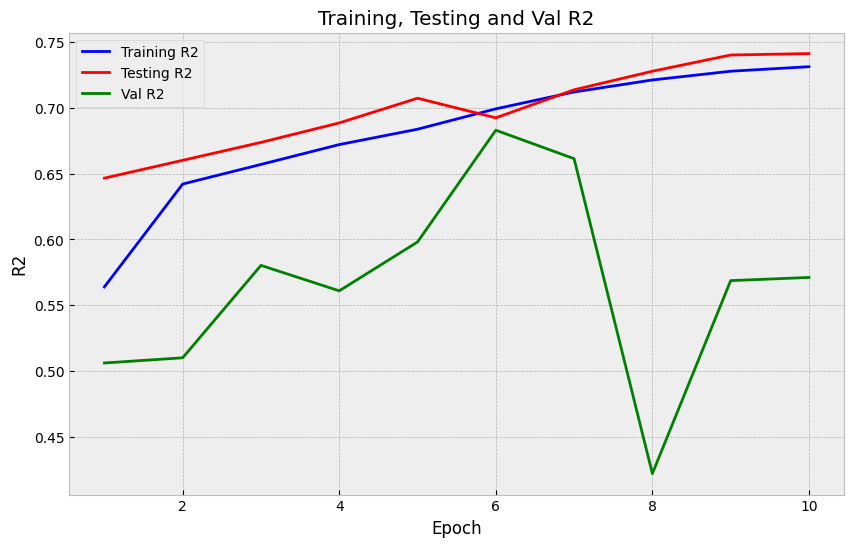

In [38]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Hyperparameters
input_size = X_train.shape[2]  # Number of features (13)
hidden_size = 128  # Size of the hidden state
output_size = 1  # RUL prediction
learning_rate = 0.0001
num_epochs = 10
batch_size = 16

# Create the LSTM model and move it to the GPU
model = LSTMModel(input_size=input_size, hidden_size=hidden_size, output_size=output_size).to(device)

# Loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Lists to store losses and metrics
train_losses = []
test_losses = []
val_losses = []
TRAIN_R2 = []
TEST_R2 = []
VAL_R2 = []

# Save best model
best_val_loss = float('inf')

# Train the model
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    train_loss = 0.0
    all_predictions = []
    all_targets = []

    for inputs, targets in train_dataloader:
        # Move data to GPU
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()  # Clear gradients
        outputs = model(inputs)  # Perform prediction
        loss = criterion(outputs.squeeze(), targets)  # Calculate loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update parameters
        train_loss += loss.item() * inputs.size(0)

        # Store predictions and targets
        all_predictions.append(outputs.squeeze().detach().cpu())  # Move to CPU for accumulation
        all_targets.append(targets.detach().cpu())

    # Calculate training metrics
    train_loss /= len(train_dataloader.dataset)
    train_losses.append(train_loss)
    train_r2 = compute_r2(all_predictions, all_targets)
    TRAIN_R2.append(train_r2)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train R2: {train_r2:.4f}')

    # Evaluate on the test set
    test_loss, test_r2, test_predictions, test_targets = model_evaluation(model, test_dataloader, device)
    test_losses.append(test_loss)
    TEST_R2.append(test_r2)
    print(f'Test Loss: {test_loss:.4f}, Test R2: {test_r2:.4f}')

    # Evaluate on the validation set
    val_loss, val_r2, val_predictions, val_targets = model_evaluation(model, val_dataloader, device)
    val_losses.append(val_loss)
    VAL_R2.append(val_r2)
    print(f'Val Loss: {val_loss:.4f}, Val R2: {val_r2:.4f}')

    # Save the best model
    best_val_loss = save_best_model(model, optimizer, epoch, val_loss, best_val_loss)

# Compare predictions with targets
all_predictions = torch.cat(all_predictions, dim=0).numpy()
all_targets = torch.cat(all_targets, dim=0).numpy()

# Plots
graph_3values(train_losses, test_losses, val_losses, 'Training Loss', 'Testing Loss', 'Val Loss', 'Epoch', 'Loss', 'Training, Testing and Val Loss')
graph_3values(TRAIN_R2, TEST_R2, VAL_R2, 'Training R2', 'Testing R2', 'Val R2', 'Epoch', 'R2', 'Training, Testing and Val R2')



##Graph

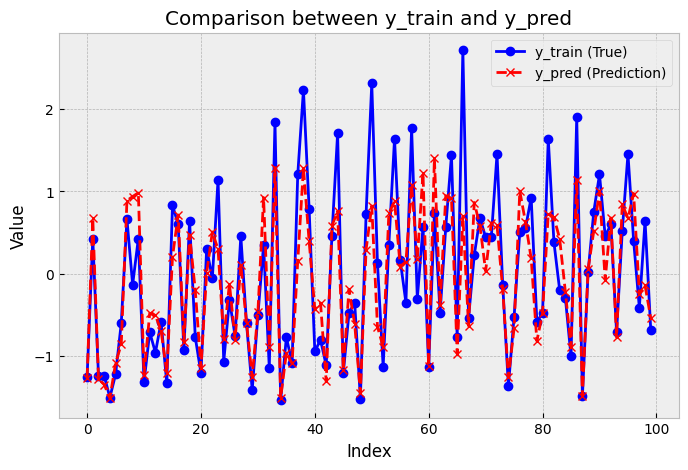

In [39]:
# Plot a comparison between the true values (y_train) and the predicted values (y_pred)
plt.figure(figsize=(8, 5))  # Set the figure size
plt.plot(all_targets[0:100], label='y_train (True)', marker='o', linestyle='-', color='blue')  # Plot true values
plt.plot(all_predictions[0:100], label='y_pred (Prediction)', marker='x', linestyle='--', color='red')  # Plot predictions

# Customize the plot
plt.title("Comparison between y_train and y_pred")  # Set the title
plt.xlabel("Index")  # Label for the x-axis
plt.ylabel("Value")  # Label for the y-axis
plt.legend()  # Add a legend
plt.grid(True)  # Add a grid

# Display the plot
plt.show()


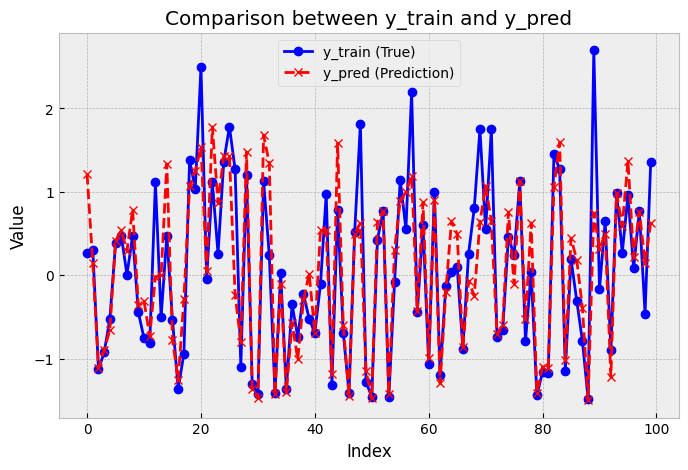

In [40]:
# Plot a comparison between the true test values (y_train) and the predicted values (y_pred)
plt.figure(figsize=(8, 5))  # Set the figure size
plt.plot(test_targets[0:100], label='y_train (True)', marker='o', linestyle='-', color='blue')  # Plot true test values
plt.plot(test_predictions[0:100], label='y_pred (Prediction)', marker='x', linestyle='--', color='red')  # Plot test predictions

# Customize the plot
plt.title("Comparison between y_train and y_pred")  # Set the title
plt.xlabel("Index")  # Label for the x-axis
plt.ylabel("Value")  # Label for the y-axis
plt.legend()  # Add a legend


0.1794748345017433 0.5710877180099487


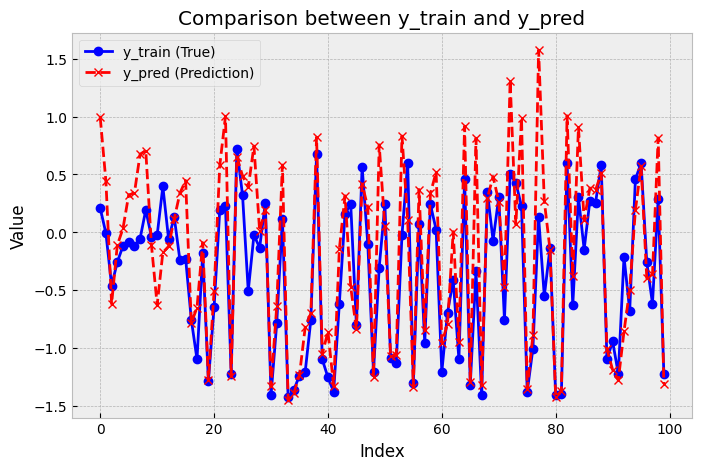

In [41]:
# Evaluate the model on the validation dataset
val_loss, val_r2, val_predictions, val_targets = model_evaluation(model, val_dataloader, device)
print(val_loss, val_r2)

# Plot a comparison between the true validation values (y_train) and the predicted values (y_pred)
plt.figure(figsize=(8, 5))  # Set the figure size
plt.plot(val_targets[0:1000], label='y_train (True)', marker='o', linestyle='-', color='blue')  # Plot true validation values
plt.plot(val_predictions[0:1000], label='y_pred (Prediction)', marker='x', linestyle='--', color='red')  # Plot predicted validation values

# Customize the plot
plt.title("Comparison between y_train and y_pred")  # Set the title
plt.xlabel("Index")  # Label for the x-axis
plt.ylabel("Value")  # Label for the y-axis
plt.legend()  # Add a legend
plt.grid(True)  # Add a grid

# Display the plot
plt.show()

Best model on validation set

<ipython-input-43-d6814c80be60>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("/content/best_model_val.pth")


0.13265799254179 0.6829714775085449


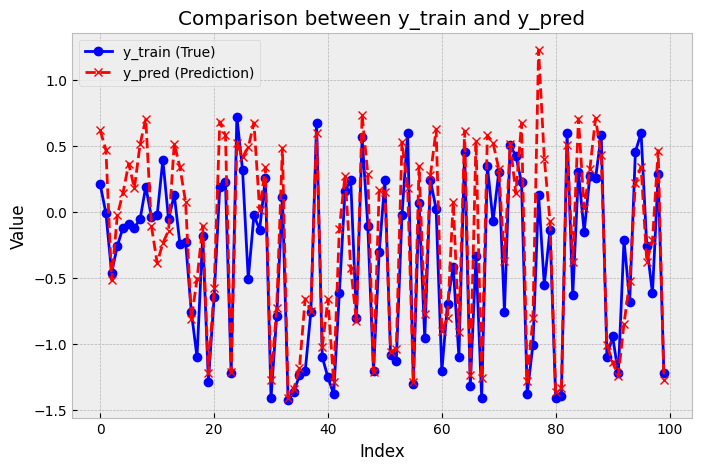

In [43]:
# Load the checkpoint from the file
checkpoint = torch.load("/content/best_model_val.pth")

# Create the LSTM model and move it to the GPU
model_val = LSTMModel(input_size=input_size, hidden_size=hidden_size, output_size=output_size).to(device)

# Load the model weights from 'model_state_dict'
model_val.load_state_dict(checkpoint['model_state_dict'])

# Evaluate the model on the validation dataset
val_loss, val_r2, val_predictions, val_targets = model_evaluation(model_val, val_dataloader, device)
print(val_loss, val_r2)

# Plot a comparison between the true validation values (y_train) and the predicted values (y_pred)
plt.figure(figsize=(8, 5))  # Set the figure size
plt.plot(val_targets[0:1000], label='y_train (True)', marker='o', linestyle='-', color='blue')  # Plot true validation values
plt.plot(val_predictions[0:1000], label='y_pred (Prediction)', marker='x', linestyle='--', color='red')  # Plot predicted validation values

# Customize the plot
plt.title("Comparison between y_train and y_pred")  # Set the title
plt.xlabel("Index")  # Label for the x-axis
plt.ylabel("Value")  # Label for the y-axis
plt.legend()  # Add a legend
plt.grid(True)  # Add a grid

# Display the plot
plt.show()


#Conclusion

The model achieves its best performance with the following metrics: Train Loss of 0.2688 and Train R² of 0.7312, Test Loss of 0.2507 and Test R² of 0.7412, and Validation Loss of 0.1327 and Validation R² of 0.6830.

The lower validation R² compared to the test R² indicates a potential sign of overfitting, where the model may be slightly over-specialized to the training data and not generalizing optimally to the validation set. Addressing overfitting could involve applying additional regularization, such as dropout or weight decay, or increasing the size of the validation set for more robust evaluation.